New red QSO Code

In [2]:
#imports placed here
import os
import pickle 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

found file 39627770262716602, but pickle is missing
found file 39627800436540700, but pickle is missing
found file 39627811958295714, but pickle is missing
found file 39633127710134030, but pickle is missing
The mean reduced chi squared is 1.606 with a standard deviation 0.659
The median reduced chi squared is 1.546
object list with reduced chi square value above 2:
['39627752105579342', '39627752122355042', '39627776315100827', '39627788335975931', '39627799819979870', '39627800482678946', '39627841591051279', '39627842727709215', '39627877838225923', '39633114284164461', '39633118654629545', '39633136572695884', '39633145246517319']
13
13


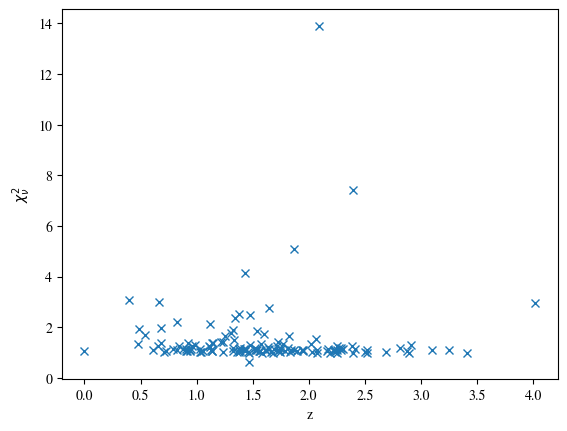

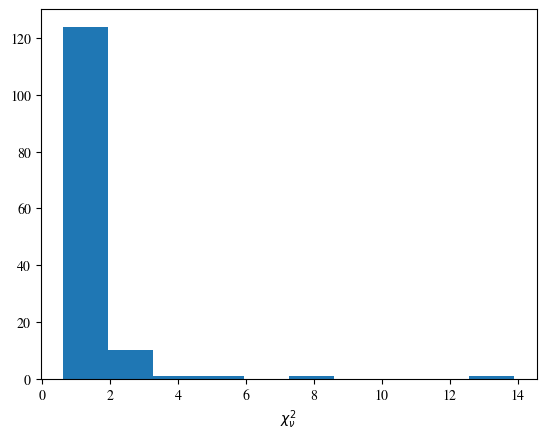

In [8]:
#Here we will inspect the contents of the pickle files for fits which exclude the host component
#first get a list of directory contents and catalogue:
fileAddress = "results/excludinghost"
catalogue = pd.read_csv("data/RedQSOCatalogue.csv")


files = list(os.listdir(fileAddress))
reducedChiSquareds = []
highChiSquareObjects = []
Zs = []
for file in files:
    #check that the file is a directory:
    if "." in file:
        continue
    if os.path.exists(f"{fileAddress}/{file}/fitting_results/{file}-result-band-g.pkl"):
        output = pickle.load(open(f"{fileAddress}/{file}/fitting_results/{file}-result-band-g.pkl","rb"))
        #print(output.final_result_ps)
        #print(output.reduced_Chisq)
        obj_No = list(catalogue["TARGETID"]).index(int(file))
        z = list(catalogue["Z"])[obj_No]
        reducedChiSquareds.append(output.reduced_Chisq)
        if output.reduced_Chisq >= 2:
            highChiSquareObjects.append(file)
        Zs.append(z)
    else:
        print(f"found file {file}, but pickle is missing")

#chi2 statistics
print(f"The mean reduced chi squared is {round(np.mean(Zs),3)} with a standard deviation {round(np.std(Zs),3)}")
print(f"The median reduced chi squared is {round(np.median(Zs),3)}")
print("object list with reduced chi square value above 2:")
print(highChiSquareObjects)
print(len(highChiSquareObjects))
#displaying plots:
plt.figure()
plt.plot(Zs,reducedChiSquareds,linestyle="None",marker="x")
plt.xlabel("z")
plt.ylabel(r"$\chi^{2}_{\nu}$")
plt.figure()
plt.xlabel(r"$\chi^{2}_{\nu}$")
plt.hist(reducedChiSquareds)
#count number of entries with higher chi square than 2
no = 0
for i in reducedChiSquareds:
    if i >= 2:
        no += 1
print(no)